In [38]:
import torch
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt

In [39]:
# fixes issues with matplotlib
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [40]:
# loading dataset
df = pd.read_csv('final_names.csv')
df.head()

,Unnamed: 0,0
0,0,Pie_a_La_Mode
1,1,Celica_A_Mercury
2,2,Konoe_A_Mercury
3,3,Priapus_A_Tarou
4,4,Faalala_Aa_Larm


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72776 entries, 0 to 72775
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72776 non-null  int64 
 1   0           72776 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [42]:
df.drop('Unnamed: 0', axis = 1, inplace = True)

In [43]:
# extracting names
words = []
for i in range(len(df)):
    words.append((df.iloc[i, 0]).lower())

words

['pie_a_la_mode',
 'celica_a_mercury',
 'konoe_a_mercury',
 'priapus_a_tarou',
 'faalala_aa_larm',
 'torry_aaes',
 'angel_aaltonen',
 'diana_aaman',
 'itsue_aasu',
 'futaba_aasu',
 'hitomi_aasu',
 'nanase_aasu',
 'mitsuki_aasu',
 'mutsumi_aasu',
 'shii_aasu',
 'lashara_aasu_xxviii',
 'kim_aba',
 'iouri_abalkin',
 'renji_abarai',
 'ichika_abarai',
 'robert_abarth',
 'kikunosuke_abashiri',
 'naojirou_abashiri',
 'daemon_abashiri',
 'kichiza_abashiri',
 'goemon_abashiri',
 'naojiro_abashiri',
 'youhei_abashiri',
 'kinzou_abashiri',
 'sosuke_abayama',
 'leone_abbacchio',
 'iino_abbav',
 'fred_abberline',
 'tiffany_abbot',
 'judy_abbott',
 'abbott',
 'majorca_abbott',
 'zach_abdullah',
 'saki_abdusha',
 'takaya_abe',
 'takakazu_abe',
 'katsuya_abe',
 'narumi_abe',
 'kakeru_abe',
 'osamu_abe',
 'shinzo_abe',
 'mitsuru_abe',
 'misae_abe',
 'shousei_abe',
 'shun_abe',
 'tamotsu_abe',
 'seimei_abe',
 'rika_abe',
 'takahiro_abe',
 'kotarou_abe',
 'gonji_abe',
 'hiroshi_abe',
 'jun_abe',
 'tamaki

In [45]:
for i in range(len(words)):
    if '-' in words[i]:
        words[i] = words[i].replace('-', '_')

In [47]:
temp = []
for w in words:
    if '#' not in w:
        temp.append(w)

words = temp.copy()
len(words)

72775

In [49]:
# vocabolary of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(stoi)
print(vocab_size)
print(itos)

38
{1: '0', 2: '1', 3: '2', 4: '3', 5: '4', 6: '5', 7: '6', 8: '7', 9: '8', 10: '9', 11: '_', 12: 'a', 13: 'b', 14: 'c', 15: 'd', 16: 'e', 17: 'f', 18: 'g', 19: 'h', 20: 'i', 21: 'j', 22: 'k', 23: 'l', 24: 'm', 25: 'n', 26: 'o', 27: 'p', 28: 'q', 29: 'r', 30: 's', 31: 't', 32: 'u', 33: 'v', 34: 'w', 35: 'x', 36: 'y', 37: 'z', 0: '.'}


In [50]:
# build dataset
block_size = 3 # how many characters to predit the next one

def build_dataset(words):
    X, Y = [], []
    for w in words: 
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train, Y_train = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

torch.Size([833821, 3]) torch.Size([833821])
torch.Size([104485, 3]) torch.Size([104485])
torch.Size([104513, 3]) torch.Size([104513])


In [104]:
# kaiming init
(5/3)/((n_embd * block_size)**0.5) # (5/3) is the gain constant for tanh activation function

0.3042903097250923

### Applying Kaiming initialization
helps in initialization the weights of the network

In [122]:
# Multi Layer Perceptron
n_embd = 10 # dimensionality of character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of MLP

g = torch.Generator().manual_seed(42)
C = torch.randn((vocab_size, n_embd),             generator = g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator = g) * (5/3)/((n_embd * block_size)**0.5)
# b1 = torch.randn(n_hidden,                      generator = g) * 0.01  Since we are using batch norm, this is useless
W2 = torch.randn((n_hidden, vocab_size),          generator = g) * 0.01
b2 = torch.randn(vocab_size,                      generator = g) * 0

# BatchNorm parameters
bn_gain = torch.ones((1, n_hidden)) # batch normalization gain
bn_bias = torch.zeros((1, n_hidden))
bn_mean_running = torch.zeros((1, n_hidden))
bn_std_running = torch.ones((1, n_hidden))

params = [C, W1, b1, W1, b2, bn_gain, bn_bias]
print("number of parameters:", sum([p.nelement() for p in params])) # number of parameters
for p in params:
    p.requires_grad = True

number of parameters: 13018


In [123]:
# optimization and training
max_steps = int(2e5)
batch_size = 32
loss_i = []
shapes = {}

for i in range(max_steps):
    
    # construct minibatch
    ix = torch.randint(0, X_train.shape[0], (batch_size, ), generator = g)
    X_batch, Y_batch = X_train[ix], Y_train[ix]
    
    shapes['X_batch'] = X_batch.shape
    shapes['Y_batch'] = Y_batch.shape
    
    # forward pass
    emb = C[X_batch] # embed characters into vectors
    emb_concat = emb.view(emb.shape[0], -1) # concat the vectors
    
    # Linear layer
    h_pre_activ = emb_concat @ W1 + b1 # hidden layer pre-activation
    
    # BatchNorm layer
    # -----------------------------------------------------------------------------
    bn_mean_i = h_pre_activ.mean(0, keepdim = True)
    bn_std_i = h_pre_activ.std(0, keepdim = True)
    h_pre_activ = bn_gain * (h_pre_activ - bn_mean_i) / bn_std_i + bn_bias
    with torch.no_grad():
        bn_mean_running = 0.999 * bn_mean_running + 0.001 * bn_mean_i
        bn_std_running = 0.999 * bn_std_running + 0.001 * bn_std_i
    # -----------------------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(h_pre_activ) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Y_batch) # loss function
    
    shapes['emb'] = emb.shape
    shapes['emb_concat'] = emb_concat.shape
    shapes['h_pre_activ'] = h_pre_activ.shape
    shapes['h'] = h.shape
    shapes['logits'] = logits.shape
    shapes['loss'] = loss.shape
    
    # backward pass
    for p in params:
        p.grad = None
    loss.backward()
    
    # update
    learn_rate = 0.1 if i < int(1e5) else 0.01 # step learning rate delay
    for p in params:
        p.data += -1 * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item(): .4f}")
        
    loss_i.append(loss.log10().item())

      0/ 200000:  3.6372
  10000/ 200000:  2.5514
  20000/ 200000:  2.5589
  30000/ 200000:  2.6694
  40000/ 200000:  2.7279
  50000/ 200000:  2.3648
  60000/ 200000:  2.4906
  70000/ 200000:  2.3589
  80000/ 200000:  2.7450
  90000/ 200000:  2.7122
 100000/ 200000:  2.4416
 110000/ 200000:  2.2218
 120000/ 200000:  2.4439
 130000/ 200000:  2.6413
 140000/ 200000:  2.6645
 150000/ 200000:  2.3834
 160000/ 200000:  2.4420
 170000/ 200000:  2.4849
 180000/ 200000:  2.5107
 190000/ 200000:  2.4507


In [109]:
shapes

{'X_batch': torch.Size([32, 3]),
 'Y_batch': torch.Size([32]),
 'emb': torch.Size([32, 3, 10]),
 'emb_concat': torch.Size([32, 30]),
 'h_pre_activ': torch.Size([32, 200]),
 'h': torch.Size([32, 200]),
 'logits': torch.Size([32, 38]),
 'loss': torch.Size([])}

In [57]:
-torch.tensor(1/38).log()

tensor(3.6376)

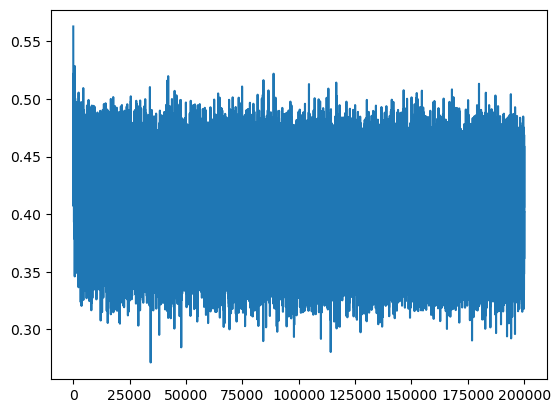

In [113]:
plt.plot(loss_i);

In [120]:
@torch.no_grad() # decorator that disables gradient tracking

def split_loss(split):
    x, y = {
        'train': {X_train, Y_train}, 
        'val': {X_val, Y_val}, 
        'test': {X_test, Y_test}
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    emb_concat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    h_pre_activ = emb_concat @ W1 + b1
    h_pre_activ = bn_gain * (h_pre_activ - bn_mean_running) / bn_std_running + bn_bias
    h = torch.tanh(h_pre_activ) # (N, hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.52060604095459
val 2.524009943008423


In [105]:
# sample from the model
g = torch.Generator().manual_seed(42)

for _ in range(20):
    out = []
    context = [0]*block_size # initialize with all "..."
    while True:
        # forward pass
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples = 1, generator = g).item()
        # shift from context window and track sample
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample special token '.', then break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out)) # print generated word

mkadnattoy.
tm_uzukairmarinoi_bitarayhia.
mk_oug.
sdi.
sorwi.
mzarjuwaes.
ivi.
ga.
shiiucimdilesmansoiertaiikcoakima.
isarustyuwhohi.
litsttsoita.
srina_hraokihrueii.
hi_ja.
mirik_edomaktaanyriee_vaz_h_s_kehnekmrak_zsr_zso_kizich_ra.
_ruro.
raimiisa.
iusdabi.
ghakaha.
trisia_le.
kaz_naa_toi.


In [70]:
# INTIAL
#train 4.356257915496826
# val 4.374621868133545

# W2 b2
#train 2.528777837753296
# val 2.5318610668182373

# W1 b1
# train 2.5056240558624268
# val 2.5089752674102783

# KAIMING 
# train 2.5077357292175293
# val 2.5108582973480225

In [140]:
# SUMMARY -----

In [233]:
class Linear:
    
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.rand((fan_in, fan_out), generator = g) / fan_in ** 0.5
        self.bias = torch.randn(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    

class BatchNorm1d:
    
    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffer (trained with a running 'momentum' update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # calculate forward pass
        if self.training:
            xmean = x.mean(0, keepdim = True) # batch mean
            xvar = x.var(0, keepdim = True, unbiased = True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum)*self.running_mean + self.momentum*xmean
                self.running_var = (1-self.momentum)*self.running_var + self.momentum*xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
    
class Tanh:
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


In [237]:
n_embd = 10 # dimensionality of character embedding vector
n_hidden = 100 # number of neurons in the hidden layer
g = torch.Generator().manual_seed(42)

C = torch.randn((vocab_size, n_embd), generator = g)
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(), 
    Linear(n_hidden, n_hidden           ), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden           ), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden           ), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden           ), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(n_hidden), 
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # total number of parameters
for p in parameters:
    p.requires_grad = True

48918


In [226]:
max_steps = int(2e5)
batch_size = 32
loss_i = []

for i in range(max_steps):
    
    # construct minibatch
    ix = torch.randint(0, X_train.shape[0], (batch_size, ), generator = g)
    X_batch, Y_batch = X_train[ix], Y_train[ix] # batch X and Y
    
    # forward pass
    emb = C[X_batch] # embedding the characters into vectors
    x = emb.view(emb.shape[0], -1) # concat the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Y_batch) # loss function
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad() ############
        
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: 
        print(f"{i:7d}/{max_steps:7d}: {loss.item(): .4f}")
    loss_i.append(loss.log10().item())
    
    break

      0/ 200000:  3.8864
